In [1]:
import sys, os
sys.path = ['./scikit-learn/build/lib.linux-x86_64-3.6/', './pythia/', './pythia/codepak/cutils/'] + sys.path
os.environ['DPCOMP_CORE'] = './dpcomp_core'

from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from log_regression import test, DPLogisticRegression
from ChoiceMaker import DTChoice
import graphviz
import copy
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [438]:
from collections import OrderedDict

In [2]:
from sklearn import tree

In [3]:
from dpcomp_core.algorithm import *
from dpcomp_core.algorithm.dawa import l1partition
from dpcomp_core.query_nd_union import ndRangeUnion
from dpcomp_core import workload
from dpcomp_core import experiment
from dpcomp_core import metric
from dpcomp_core import dataset
import p_helper
import codepak.l1partition

import pickle

In [21]:
class Data:
    def __init__(self, data, dom_size, scale, wktype, eps):
        if(isinstance(data, dataset.Dataset)):
            x = np.around(data.payload)
        else:
            x = np.array(data)
        self.x = x
        self.dom_size = dom_size
        self.scale = scale
        if(wktype):
            self.Q = workload.Prefix1D(domain_shape_int=dom_size)
        else:
            self.Q = workload.Identity((dom_size,))
        self.wkload_type = wktype
        self.epsilon = eps 
    @classmethod
    def from_name(cls, dbname, dom_size, scale, wktype, eps):
        x = dataset.DatasetSampledFromFile(nickname=dbname,
            sample_to_scale=int(scale), reduce_to_dom_shape=int(dom_size),
            seed=12345)
        return cls(x, dom_size, scale, wktype, eps)
class HistAlgo:
    def __init__(self, name, seed=12345):
        self.S = np.random.RandomState(seed)
        self.name = name

    def error(self, data):
        R = self._alg.Run(data.Q, data.x, data.epsilon, self.S.randint(2**32))
        return np.linalg.norm(R-data.x)

    def run(self, data):
        R = self._alg.Run(data.Q, data.x, data.epsilon, self.S.randint(2**32))
        return R

In [149]:
class Dawa(HistAlgo):
    def __init__(self, seed=12345):
        self._alg = dawa.dawa_engine()
        super().__init__("DAWA", seed)

class Identity(HistAlgo):
    def __init__(self, seed=12345):
        self._alg = identity.identity_engine()
        super().__init__("Id", seed)

#We don't use this algorithm; haha
class Hb(HistAlgo):
    def __init__(self):
        self._alg = HB.HB_engine()
        super().__init__("Hb")
hist_list = {'Dawa': Dawa(), 'Laplace': Identity()}

class Oracle(HistAlgo):
    def __init__(self):
        self._dawa = Dawa()
        self._id = Identity()
    def run(self, data):
        E1 = self._dawa.error(data)
        E2 = self._id.error(data)
        R1 = self._dawa.run(data)
        R2 = self._id.run(data)
        if E1 < E2:
            return R1
        else:
            return R2

In [641]:
db = Data.from_name('ADULT', 2048, 512, False, 1.0)

In [647]:
dfadult1 = pickle.load(open('NaiveBayes/alg_errors/e1.0/ADULTFRANK.I.2048.pkl', 'rb'), encoding='bytes')

In [648]:
print( np.array([Identity(s).error(db) for s in range(500)]).mean() )
print( dfadult1[b'Laplace'][512] )

63.9931155191
{b'all': [], b'avg': 63.614045037786717, b'yerr': array([ 0.76519422,  0.57961766])}


In [652]:
print( np.array([Dawa(s).error(db) for s in range(500)]).mean() )

7.44412475699


In [651]:
print( np.array([Dawa(s).error(db) for s in range(500)]).std() )

1.52521191848


In [650]:
print( dfadult1[b'Dawa'][512])

{b'all': [], b'avg': 7.733969583097279, b'yerr': array([ 1.04506863,  0.49856499])}


In [394]:
arr = []
for scale in [128, 256, 512, 1024, 2048, 4096]:
    dfadult = pickle.load(open('NaiveBayes/alg_errors/e' + str(1.0) + '/ADULTFRANK.I.' + str(scale) + '.pkl', 'rb'), encoding='bytes')
    arr.append([ dfadult[b'Dawa'][x][b'avg'] for x in dfadult1[b'Dawa'].keys() ])
arr = np.array(arr)

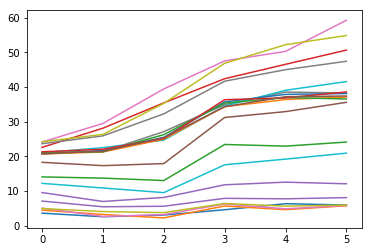

In [403]:
plt.plot(arr)

In [105]:
dfadult1[b'Laplace'].keys()

dict_keys([32, 64, 4096, 262144, 1024, 8192, 128, 524288, 256, 16384, 4194304, 2097152, 8388608, 1048576, 512, 16777216, 131072, 32768, 65536, 2048])

In [106]:
dfadult1[b'Dawa'][256]

{b'all': [],
 b'avg': 5.625782268768063,
 b'yerr': array([ 1.28758946,  0.8536528 ])}

In [107]:
dfadult1[b'Laplace'][256]

{b'all': [],
 b'avg': 63.736107805382574,
 b'yerr': array([ 1.06448977,  0.88103967])}

In [79]:
dfadult1[b'Dawa'][8388608]

{b'all': [],
 b'avg': 35.334705987028613,
 b'yerr': array([ 2.29608369,  1.51453763])}

In [439]:
class HistMetafeats:
    def __init__(self, seed=12345):
        self.S = np.random.RandomState(seed)
        self.sensitivities = OrderedDict((('scale', 0), ('domsize', 0), ('nnz', 1), ('tvd', 2), ('partition', 2)))
    @staticmethod
    def dev(H):
        return np.linalg.norm(H-H.mean(), ord=1)
    def min_cost(self, H):
        dw_part = codepak.l1partition.L1partition_true(H.astype('int32'), 1, 0.3, gethist=False)
        return p_helper.pcost(dw_part, H, 0.7)
    def __call__(self, data):
        if(isinstance(data.x, dataset.DatasetSampledFromFile)):
            x = data.x.payload
        else:
            x = data.x
        #Instead of having epsilon be a metafeature, multiply database histogram
        #by epsilon and pretend epsilon=1. Verify that all metafeatures will
        #the same relative noise added to them
        H = np.around(x*data.epsilon).astype('int')
        nnz = np.count_nonzero(H)
        tvd = HistMetafeats.dev(H)
        cost = self.min_cost(H)
        return OrderedDict((('scale', data.scale), ('domsize', data.dom_size),
                             ('nnz', nnz), ('tvd', tvd), ('partition', cost)))

In [47]:
prng = np.random.RandomState(12246)
scales=np.power(2, np.arange(5, 25))
dom_sizes = np.power(2, np.arange(7, 13))
epsilon=1

In [495]:
pickle.dump(regrets_avg, open('DTree/regrets.pkl', 'wb'))
pickle.dump(feats, open('DTree/feats.pkl', 'wb'))

In [48]:
regrets_avg = []
feats = []
filenames = ['ADULTFRANK', 'INCOME', 'MEDCOST', 'NETTRACE', 'PATENT', 'SEARCHLOGS']
dsizes = [128, 256, 512, 1024, 2048, 4096] #We didn't include 8192 because reshaping takes too long!
scales = np.power(2, np.add(range(20), 5))
epsilon = 0.2
for f in filenames:
    for k in dsizes:
        print(len(regrets_avg))
        with open('NaiveBayes/alg_errors/e' + str(epsilon) + '/' + 
                 f + '.I.' + str(k) + '.pkl', 'rb') as input:
            D = pickle.load(input, encoding='bytes')
            for scale in scales:
                regrets_avg.append({'Laplace': D[b'Laplace'][scale][b'avg'], 'Dawa': D[b'Dawa'][scale][b'avg']})
            
            input.close()
        x = np.load('dpcomp_core/datafiles/1D/' + f + '.n4096.npy')
        x = p_helper.change_size(x, k)
        for scale in scales:
            x = np.divide(x, float(sum(x))/scale, dtype=float)
            dw_part = codepak.l1partition.L1partition_true(x.astype('int32'), 1, 0.3, gethist=False)
            dw_score = p_helper.pcost(dw_part, x, 0.7)
            tvd = np.linalg.norm(x-x.mean(), ord=1)
            
            feats.append({'scale': scale, 'domsize': k, 'nnz': np.count_nonzero(x),
                          'tvd': tvd, 'partition': dw_score})

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700


In [497]:
regrets_avg = []
feats = []
filenames = ['ADULTFRANK', 'INCOME', 'MEDCOST', 'NETTRACE', 'PATENT', 'SEARCHLOGS']
dsizes = [128, 256, 512, 1024, 2048, 4096] #We didn't include 8192 because reshaping takes too long!
scales = np.power(2, np.add(range(20), 5))
epsilon = 0.1
for f in filenames:
    for k in dsizes:
        x = np.load('dpcomp_core/datafiles/1D/' + f + '.n4096.npy')
        x = p_helper.change_size(x, k)

        for scale in scales:
            x = np.divide(x, float(sum(x))/scale, dtype=float)
            db = Data(x.astype(int), k, scale, False, epsilon)
            regrets_avg.append({'Laplace': hist_list['Laplace'].error(db), 'Dawa': hist_list['Dawa'].error(db)})
            """
            dw_part = codepak.l1partition.L1partition_true(x.astype('int32'), 1, 0.3, gethist=False)
            dw_score = p_helper.pcost(dw_part, x, 0.7)
            tvd = np.linalg.norm(x-x.mean(), ord=1)
            
            feats.append(OrderedDict((('scale', scale), ('domsize', k), ('nnz', np.count_nonzero(x)),
                          ('tvd', tvd), ('partition', dw_score))) )
            """

In [499]:
feats = pickle.load(open('DTree/feats.pkl', 'rb'))

In [500]:
feats = pd.DataFrame(feats)
regrets_avg = pd.DataFrame(regrets_avg)
big_cm = DTChoice(feats, HistMetafeats(), hist_list, regrets=regrets_avg / regrets_avg.max())

In [50]:
Xs = pd.concat(obj.X for obj in cms).reset_index(drop=True)
ys = pd.concat(obj.y for obj in cms).reset_index(drop=True)
regrets = pd.concat(obj.regrets for obj in cms).reset_index(drop=True).drop('hb', axis=1)
big_cm = DTChoice(Xs, HistMetafeats(), hist_list, regrets=regrets)

NameError: name 'cms' is not defined

In [501]:
big_cm.C = 0
big_cm.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
big_cm.retrain_model()

In [502]:
big_cm.regrets.mean(axis=0)

Dawa       0.180754
Laplace    0.476664
dtype: float64

In [503]:
big_cm.X

,scale,domsize,nnz,tvd,partition
0,32,128,51,6.049655e+01,5.048563
1,64,128,51,1.209931e+02,7.239983
2,128,128,51,2.419862e+02,11.622823
3,256,128,51,4.839724e+02,17.996916
4,512,128,51,9.679447e+02,28.658681
5,1024,128,51,1.935889e+03,35.987023
6,2048,128,51,3.871779e+03,50.170636
7,4096,128,51,7.743558e+03,66.780243
8,8192,128,51,1.548712e+04,82.715333
9,16384,128,51,3.097423e+04,99.736461


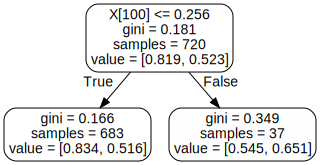

In [504]:
dot_data = export_graphviz(big_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [449]:
big_cm.trans[100-5].coefs

[0, -1, 0, 0, 1]

In [ ]:
#partition / domsize <= 0.778

In [425]:
np.exp(-0.251)

0.77802237155895726

In [557]:
#Run on credit card default dataset
skin = pd.read_csv('data/Skin.csv', sep='\t', header=None)
skin = skin.apply(lambda x: x-x.min())
skin[3] = skin[3].astype('category')
#skin[2] = skin[2].divide(8).astype('int')
#skin[1] = skin[1].divide(32).astype('int')
skin_shape = skin.apply(pd.Series.nunique)

In [558]:
default = pd.read_csv('data/default.csv', header=1)
default = default.apply(lambda x: x-x.min())
default = default.drop('ID', axis=1)
default['default payment next month'] = default['default payment next month'].astype('category')
#default.apply(pd.Series.nunique)

In [694]:
class SimpleCM:
    def __init__(self):
        self.h = HistMetafeats()
    def choose(self, db):
        metas = self.h(db)
        p = metas['partition'] + np.random.laplace(0, 2/(0.2*db.epsilon))
        p = max(p, 0.1)
        d = metas['domsize']
        db.epsilon *= 0.8
        if np.log(p/d) <= 0.256:
            return hist_list['Dawa'].run(db)
        else:
            return hist_list['Laplace'].run(db)

In [850]:
def PrivateNaiveBayes(db, test, budget, shape, method='multinomial', choicemaker=None, alg=None, prng=None):
    k = len(db.columns)
    epsilon = budget/k
    y_name = db.columns[-1]
    ys = db[y_name]
    [i0, i1] = db[y_name].cat.categories
    if prng is None:
        prng = np.random.RandomState()
    ys_prob = Data(pd.value_counts(ys).sort_index(), shape[db.columns[-1]], len(ys), False, epsilon)
    if choicemaker is None:
        Hy = alg[0].run(ys_prob)
    else:
        Hy = choicemaker.choose(ys_prob)
    #Hy = get_hist(ys, epsilon, prng, shape[db.columns[-1]])
    Hy /= Hy.sum()
    l2 = np.linalg.norm(Hy - ys_prob.x/ys_prob.x.sum())
    #total_probs0 = np.repeat(Hy[i0], len(test))
    #total_probs1 = np.repeat(Hy[i1], len(test))
    num_zeros = (ys == i0).sum()
    num_ones = (ys == i1).sum()
    avg_l2 = []
    for c in db.columns[:-1]:
        cnts = pd.value_counts(db[ys == i0][c])
        hist0 = np.zeros(shape[c], dtype='int32')
        hist0[cnts.index] += cnts
        col0_hist = Data(hist0, shape[c], num_zeros, False, epsilon)
        if choicemaker is None:
            histx0 = alg[1].run(col0_hist)
        else:
            histx0 = choicemaker.choose(col0_hist)
        histx0[histx0 < 0] = 0
        avg_l2.append(np.linalg.norm(col0_hist.x - histx0))
        histx0 /= histx0.sum()
        if method == 'multinomial':
            total_probs0 = histx0[test[c]]
        elif method == 'gaussian':
            mu = histx0.dot(np.arange(len(histx0)))
            S = np.arange(len(histx0)) - mu
            std = np.sqrt((S*S).dot(histx0))
            total_probs0 = 1/std * np.exp(-(test[c] - mu)**2 / (2*std*std))
        else:
            assert False
        cnts = pd.value_counts(db[ys == i1][c])
        hist1 = np.zeros(shape[c], dtype='int32')
        hist1[cnts.index] += cnts
        col1_hist = Data(hist1, shape[c], num_ones, False, epsilon)
        if choicemaker is None:
            histx1 = alg[1].run(col1_hist)
        else:
            histx1 = choicemaker.choose(col1_hist)
        histx1[histx1 < 0] = 0
        avg_l2.append(np.linalg.norm(col1_hist.x - histx1))
        histx1 /= histx1.sum()
        if method == 'multinomial':
            total_probs1 = histx1[test[c]]
        elif method == 'gaussian':
            mu = histx1.dot(np.arange(len(histx1)))
            S = np.arange(len(histx1)) - mu
            std = np.sqrt((S*S).dot(histx1))
            total_probs1 = 1/std * np.exp(-(test[c] - mu)**2 / (2*std*std))
        else:
            assert False
        total_probs0 *= Hy[i0]
        total_probs1 *= Hy[i1]
    total_probs0[np.isnan(total_probs0)] = 0
    total_probs1[np.isnan(total_probs1)] = 0
    P = total_probs0 / (total_probs1 + total_probs0)
    P[np.isnan(P)] = 0.5
    return (P, l2, sum(avg_l2) / len(avg_l2))

In [793]:
def run_tests(db, db_shape, big_cm, eps, method='multinomial'):
    perfs = []
    for y in range(0, 100):
        for x in np.arange(1000, 15000, 2000):
            perf_size={'size' : x}
            train = db.sample(x, replace=True).reset_index(drop=True)
            test = db.sample(1000, replace=True).reset_index(drop=True)
            #probs = PrivateNaiveBayes(train, test, eps, db_shape, big_cm)
            ### for z in range(0, 5):
            (probs, l2, l2_other) = PrivateNaiveBayes(train, test, eps, db_shape, 
                                                      choicemaker=SimpleCM(), method=method)
            perf_size['cm'] = roc_auc_score(test[3], probs)
            perf_size['l2cm'] = l2
            perf_size['l2cm_other'] = l2_other
            for name, alg in hist_list.items():
                (probs, l2, l2_other) = PrivateNaiveBayes(train, test, eps, db_shape, 
                                                          alg=[alg, alg], method=method)
                perf_size[name] = roc_auc_score(test[3], probs)
                perf_size['l2' + name] = l2
                perf_size['l2' + name + '_other'] = l2_other
            (probs, l2, l2_other) = PrivateNaiveBayes(train, test, eps, db_shape, 
                                                      alg=[hist_list['Laplace'], hist_list['Dawa']], method=method)
            perf_size['oracle'] = roc_auc_score(test[3], probs)
            perf_size['l2oracle'] = l2
            perf_size['l2oracle_other'] = l2_other
            perfs.append(perf_size)
    return pd.DataFrame(perfs)

In [878]:
results_normal = run_tests(skin, skin_shape, big_cm, 0.8, method='gaussian')

In [880]:
results_normal.groupby('size').mean()

,Dawa,Laplace,cm,l2Dawa,l2Dawa_other,l2Laplace,l2Laplace_other,l2cm,l2cm_other,l2oracle,l2oracle_other,oracle
size,,,,,,,,,,,,
1000,0.092256,0.092647,0.092046,0.012392,33.223481,0.006482,83.142245,0.013198,35.345428,0.006148,33.743324,0.092137
3000,0.092318,0.092398,0.092403,0.003925,59.181229,0.001925,89.724799,0.002699,64.162023,0.001932,59.006608,0.092343
5000,0.092675,0.092679,0.092681,0.001862,74.813286,0.001187,94.298529,0.002205,81.899599,0.001271,74.698125,0.092681
7000,0.092216,0.092229,0.092224,0.001969,85.874273,0.000819,97.034095,0.001303,95.343791,0.000892,85.782140,0.092224
9000,0.091868,0.091869,0.091854,0.001355,94.371955,0.000727,99.030475,0.001099,105.173659,0.000621,93.604655,0.091866
11000,0.092073,0.092077,0.092063,0.000945,99.960541,0.000480,100.909144,0.001056,113.660112,0.000550,100.820890,0.092073
13000,0.090826,0.090825,0.090817,0.000785,106.778357,0.000414,101.665540,0.000928,119.630681,0.000445,106.690915,0.090821


In [853]:
results_multi = run_tests(skin, skin_shape, big_cm, 0.8, method='multinomial')

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

In [927]:
pickle.dump(results_multi, open('NaiveBayes/results_multi,pkl', 'wb'))
pickle.dump(results_multi, open('NaiveBayes/results_normal.pkl', 'wb'))

In [883]:
resm = results_multi.groupby('size').mean()
resm

,Dawa,Laplace,cm,l2Dawa,l2Dawa_other,l2Laplace,l2Laplace_other,l2cm,l2cm_other,l2oracle,l2oracle_other,oracle
size,,,,,,,,,,,,
1000,0.147868,0.354695,0.156186,0.012253,34.096505,0.006783,83.001592,0.011242,35.406122,0.005708,33.744539,0.151116
3000,0.107821,0.228117,0.118881,0.004059,59.462574,0.002069,89.779860,0.003613,64.736508,0.002168,59.587332,0.105339
5000,0.091998,0.177208,0.099542,0.002312,74.540675,0.001118,94.056052,0.002696,81.635322,0.001252,74.537581,0.094811
7000,0.086163,0.150821,0.089451,0.001551,85.955534,0.000720,96.925685,0.001456,95.273620,0.000948,84.655157,0.085445
9000,0.078397,0.130769,0.082175,0.001442,94.311370,0.000671,99.083061,0.001055,104.655719,0.000679,93.752856,0.079968
11000,0.076318,0.117080,0.079994,0.001139,100.011657,0.000585,100.343433,0.000973,112.645924,0.000526,100.647957,0.075784
13000,0.075258,0.108273,0.077487,0.000891,106.534775,0.000427,101.427877,0.000763,120.084317,0.000391,106.753922,0.074967


In [915]:
juxtaposed_alg_perfs = np.array(resm[['Dawa', 'Laplace', 'cm', 'oracle']].loc[[1000, 5000, 11000]]).flatten()

In [903]:
colors = ['red', 'blue', 'green', 'gray']*3
x_pos = np.array([5*x + y for x in [0,1,2] for y in [0,1,2,3]])

In [905]:
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=c) for c in ['red', 'blue', 'green', 'gray']]

<Container object of 12 artists>

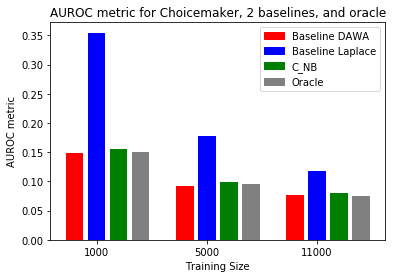

In [924]:
fig, axis = plt.subplots()
axis.set_xticks([1,6, 11])
axis.set_xticklabels(['1000', '5000', '11000'])
axis.set_xlabel('Training Size')
axis.set_ylabel('AUROC metric')
axis.legend(handles=patches, labels=['Baseline DAWA', 'Baseline Laplace', 'C_NB', 'Oracle'])
axis.set_title('AUROC metric for Choicemaker, 2 baselines, and oracle')
axis.bar(x_pos, juxtaposed_alg_perfs, color=colors)